In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection

from recommend.utils import PROJ_ROOT
from recommend.cf_recommenders import CFBaseline, CFGradFactor

In [2]:
ratings = pd.read_pickle(f"{PROJ_ROOT}/data/ratings.pkl")

In [3]:
ratings.shape

(2797751, 5)

In [4]:
def filter_ratings(ratings: pd.DataFrame, min_user_ratings: int, min_movie_ratings: int) -> pd.DataFrame:
    ratings = ratings.dropna()

    user_rating_count = ratings.groupby("username").size()
    worthy_users = set(user_rating_count[user_rating_count >= min_user_ratings].index)
    ratings = ratings.loc[ratings.username.isin(worthy_users)]

    movie_rating_count = ratings.groupby("movie_id").size()
    worthy_movies = set(movie_rating_count[movie_rating_count >= min_movie_ratings].index)
    ratings = ratings.loc[ratings.movie_id.isin(worthy_movies)]
    
    return ratings

In [5]:
ratings = filter_ratings(ratings, 10, 10)

In [6]:
ratings.shape

(2722362, 5)

In [7]:
ratings_train, ratings_test = sklearn.model_selection.train_test_split(
    ratings,
    test_size=0.1,
    shuffle=True,
    random_state=0,
)

ratings_train, ratings_valid = sklearn.model_selection.train_test_split(
    ratings_train,
    test_size=0.1,
    shuffle=True,
    random_state=0,
)

In [8]:
ratings_train.head()

,username,movie_id,stars,date,comment
328863,pepo,2596-osm-a-pul,1.0,2018-04-24,"Súhlasím, že 8 1/2 je umelecký film. Je totiž..."
1601217,Melly.pro,224137-hvezdny-prach,5.0,2008-01-18,"Tak nejsem si úplně jistej, co o tom říct, pr..."
1369474,GOREGASM,223564-kazatel,2.0,2016-01-31,Béčkové vody zakalené do digitálního apokalyp...
499592,Ernie_13,308635-zpatky-ve-hre,3.0,2014-03-07,"No je to tých 70%....hrozná réžia, hrozný sce..."
2322162,Khumbac,71194-walker-texas-ranger,4.0,2012-07-14,"Z nostalgie, z recese, z úcty ke komedii dává..."


<AxesSubplot:>

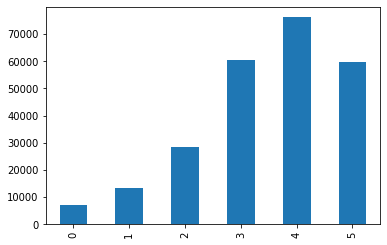

In [9]:
ratings_valid.stars.apply(int).value_counts().sort_index().plot.bar()

In [10]:
baseline = CFBaseline()
baseline.train(ratings_train)

In [11]:
recommender = CFGradFactor(
    all_movies=ratings.movie_id.unique().tolist(),
    all_users=ratings.username.unique().tolist(),
    num_features=100,
)


In [12]:
recommender.train(
    ratings_train,
    ratings_valid,
    path_to_save=f"{PROJ_ROOT}/models/cf_recommender.pt"
)

In [13]:
recommender_big = CFGradFactor(
    all_movies=ratings.movie_id.unique().tolist(),
    all_users=ratings.username.unique().tolist(),
    num_features=300,
    scale=0.3
)

In [14]:
recommender_big.train(
    ratings_train,
    ratings_valid,
    patience=5,
    path_to_save=f"{PROJ_ROOT}/models/cf_recommender_big.pt",
)


In [15]:
"""recommender_tiny = CFGradFactor(
    all_movies=ratings.movie_id.unique().tolist(),
    all_users=ratings.username.unique().tolist(),
    num_features=50,
)"""
None

In [16]:
# recommender_tiny.train(ratings_train, ratings_valid)

<AxesSubplot:>

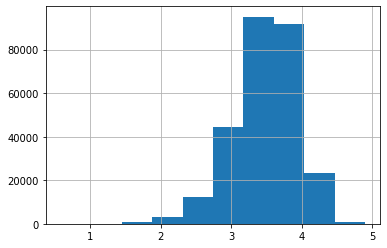

In [17]:
pd.Series(baseline.predict_ratings(ratings_test.movie_id, ratings_test.username)).hist()

<AxesSubplot:>

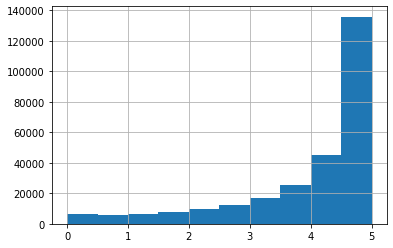

In [18]:
pd.Series(recommender.predict_ratings(ratings_test.movie_id, ratings_test.username)).hist()

<AxesSubplot:>

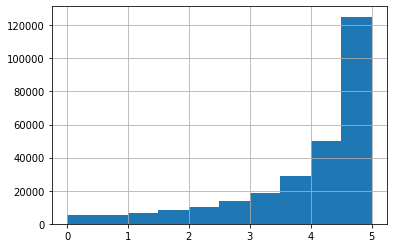

In [19]:
pd.Series(recommender_big.predict_ratings(ratings_test.movie_id, ratings_test.username)).hist()


In [20]:
df_movies = pd.read_pickle(f"{PROJ_ROOT}/data/movies.pkl")
df_movies

,title,description,kind,genres,countries,year,length,poster,foreign_titles,creators
movie_id,,,,,,,,,,
230421-houbicky,Houbičky,"Partička amerických teenagerů, která si vyrazi...",movie,"[Horor, Thriller]","[Irsko, Velká Británie, Dánsko]",2007,84 min,//image.pmgstatic.com/cache/resized/w420/files...,{'Irsko': 'Shrooms'},"{'Režie': [('/tvurce/4690-paddy-breathnach/', ..."
10789-prvni-liga,První liga,V nejvyšší lize získávají hráči baseballu boha...,movie,"[Komedie, Sportovní]",[USA],1989,107 min,//image.pmgstatic.com/cache/resized/w420/files...,"{'USA': 'Major League', 'Slovensko': 'Prvá liga'}","{'Režie': [('/tvurce/4010-david-s-ward/', 'Dav..."
235032-yes-man,Yes Man,"Carl Allen je zatrpklý bankovní úředník, který...",movie,"[Komedie, Romantický]",[USA],2008,100 min,//image.pmgstatic.com/files/images/film/poster...,"{'Austrálie': 'Yes Man', 'Kanada': 'Yes Man', ...","{'Režie': [('/tvurce/8883-peyton-reed/', 'Peyt..."
234754-chlapec-v-pruhovanem-pyzamu,Chlapec v pruhovaném pyžamu,Osmiletý Bruno žije se svojí rodinou v Berlíně...,movie,"[Drama, Válečný]","[Velká Británie, USA]",2008,94 min,//image.pmgstatic.com/files/images/film/poster...,"{'USA': 'The Boy in the Striped Pajamas', 'ang...","{'Režie': [('/tvurce/6600-mark-herman/', 'Mark..."
301717-nejvetsi-showman,Největší showman,Hugh Jackman vévodí hvězdnému obsazení odvážné...,movie,"[Muzikál, Životopisný, Drama]",[USA],2017,105 min,//image.pmgstatic.com/cache/resized/w420/files...,"{'USA': 'The Greatest Showman', 'Slovensko': '...","{'Režie': [('/tvurce/78497-michael-gracey/', '..."
...,...,...,...,...,...,...,...,...,...,...
9443-paralelni-svety,Paralelní světy,Film Paralelní světy vypráví zdánlivě obyčejný...,movie,"[Drama, Psychologický]","[Česko, Francie, Nizozemsko]",2001,100 min,//image.pmgstatic.com/cache/resized/w140/files...,"{'Francie': 'Les mondes parallèles', 'angličti...","{'Režie': [('/tvurce/3317-petr-vaclav/', 'Petr..."
221264-zivot-jde-dal,Život jde dál,Po smrti svého snoubence se Gray (Jennifer Gar...,movie,"[Komedie, Romantický, Drama]",[USA],2006,107 min,//image.pmgstatic.com/cache/resized/w420/files...,"{'USA': 'Catch and Release', 'Slovensko': 'Živ...","{'Režie': [('/tvurce/26116-susannah-grant/', '..."
128968-spionky,Špionky,"Sú mladé a krásne. Puberťáčky Sam, Alex a Clev...",series,"[Animovaný, Komedie, Akční]","[Francie, Kanada, USA]",(2001–2013),57 h 12 min\n\t\t\t\t\t(Minutáž: 22 min),//image.pmgstatic.com/cache/resized/w420/files...,"{'Česko': 'Totally Spies - Špiónky', 'Francie'...","{'Tvůrci': [('/tvurce/439025-david-michel/', '..."


In [21]:
from sklearn.metrics import mean_absolute_error

baseline_preds = baseline.predict_ratings(ratings_test.movie_id, ratings_test.username)
mean_absolute_error(ratings_test.stars, baseline_preds)

0.853504197963633

In [22]:
model_preds = recommender.predict_ratings(ratings_test.movie_id, ratings_test.username)
mean_absolute_error(ratings_test.stars, model_preds)

0.9364440712143296

In [23]:
model_preds = recommender.predict_ratings(ratings_test.movie_id, ratings_test.username)
mean_absolute_error(ratings_test.stars, model_preds.astype(int))

0.8556588560702623

In [24]:
mean_absolute_error(ratings_test.stars, np.ones_like(ratings_test.stars) * ratings_test.stars.mean())

1.0590067022133107

In [25]:
model_big_preds = recommender_big.predict_ratings(ratings_test.movie_id, ratings_test.username)
mean_absolute_error(ratings_test.stars, model_big_preds)

0.9126346023015908

In [26]:
df_movies.loc[recommender.recommend_from_movie(
    #"393331-avengers-infinity-war"
    #"234460-skyfall"
    #"110420-mission-impossible-iii"
    #"5992-marecku-podejte-mi-pero"
    #"19838-doba-ledova"
    "301401-rivalove"
)]["genres"]

movie_id
29722-guru                     [Komedie, Romantický, Hudební, Fantasy]
69880-miluji-te-k-sezrani                     [Horor, Thriller, Drama]
15046-podraz                                   [Drama, Komedie, Krimi]
234497-max-manus             [Válečný, Historický, Drama, Životopisný]
18137-jak-na-vec                          [Komedie, Drama, Romantický]
159947-milagros                               [Telenovela, Romantický]
248751-bourneuv-odkaz                   [Akční, Dobrodružný, Thriller]
223561-neznamy-svudce            [Krimi, Drama, Mysteriózní, Thriller]
280119-terra-nova                   [Dobrodružný, Mysteriózní, Sci-Fi]
12877-caligula                      [Drama, Historický, Pornografický]
14679-kdyby                                                    [Drama]
11688-dlouha-cesta                                 [Drama, Romantický]
17800-jdi-za-svym-srdcem                  [Komedie, Drama, Romantický]
241247-umeni-lhat                       [Komedie, Romantický, Fantas